In [123]:
import pandas
import numpy
import matplotlib
import os
import seaborn as sns
import numpy as np
import sklearn
import torch
import torch.nn as nn

In [124]:
df_raw = pandas.read_csv('./data/italy/covid19_italy_region.csv',
                        usecols=["Date", "RegionName", "Latitude", "Longitude", 
                        "NewPositiveCases", "TotalPositiveCases", "Deaths",
                        "TotalHospitalizedPatients", "IntensiveCarePatients"],
                        parse_dates=["Date"])
df_raw['Date'] = df_raw['Date'].dt.date
df_raw.set_index(["Date"], inplace=True)
df_raw.head()

,RegionName,Latitude,Longitude,IntensiveCarePatients,TotalHospitalizedPatients,NewPositiveCases,Deaths,TotalPositiveCases
Date,,,,,,,,
2020-02-24,Abruzzo,42.351222,13.398438,0,0,0,0,0
2020-02-24,Basilicata,40.639471,15.805148,0,0,0,0,0
2020-02-24,Calabria,38.905976,16.594402,0,0,0,0,0
2020-02-24,Campania,40.839566,14.250850,0,0,0,0,0
2020-02-24,Emilia-Romagna,44.494367,11.341721,2,12,18,0,18


In [125]:
df_pop =  pandas.read_csv('./data/italy/region_population.csv', index_col=['Territory'])

In [126]:
lat_df = df_raw[["RegionName", "Latitude", "Longitude"]]
lat_df = lat_df.drop_duplicates().sort_values(['Latitude'], ascending=False)
regions = lat_df['RegionName'].to_numpy()
lat_df

,RegionName,Latitude,Longitude
Date,,,
2020-02-24,P.A. Bolzano,46.499335,11.356624
2020-02-24,P.A. Trento,46.068935,11.121231
2020-02-24,Valle d'Aosta,45.737503,7.320149
2020-02-24,Friuli Venezia Giulia,45.649435,13.768136
2020-02-24,Lombardia,45.466794,9.190347
2020-02-24,Veneto,45.434905,12.338452
2020-02-24,Piemonte,45.073274,7.680687
2020-02-24,Emilia-Romagna,44.494367,11.341721
2020-02-24,Liguria,44.411493,8.932699


In [127]:
df_for_regions = {}
for region in regions:
    regional_df = df_raw.loc[df_raw.RegionName == region].copy()
    regional_df.drop(['RegionName', 'Latitude', 'Longitude'], axis=1, inplace=True)
    regional_df = regional_df.sort_values('Date')
    regional_df[['NewPositiveCaseDensity', 'DeathDensity', 'TotalPositiveCaseDensity']] = regional_df[["NewPositiveCases", "Deaths", "TotalPositiveCases"]] * 10000/df_pop.Value[region]
    regional_df[regional_df < 0] = 0
    regional_df = regional_df.iloc[0:150]
    regional_df = (regional_df-regional_df.min())/(regional_df.max()-regional_df.min())
    df_for_regions[region] = regional_df
df_for_regions['Abruzzo'].shape

(150, 8)

In [128]:
from matplotlib import pyplot as plt
sns.set(rc={'figure.figsize':(11.7,8.27)})

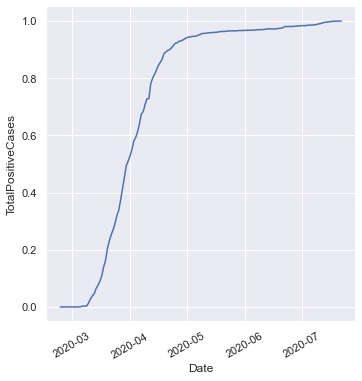

In [129]:
### plotting for P.A. Bolzano
plot = sns.relplot(data= df_for_regions['P.A. Bolzano'], x='Date', y='TotalPositiveCases', kind='line')
plot.set_xticklabels(rotation=30)

In [130]:
train_regions = np.array(['P.A. Bolzano', 'Emilia-Romagna', 'Liguria', 'Lombardia', 'Piemonte', 'P.A. Trento', "Valle d'Aosta", 'Veneto','Friuli Venezia Giulia'])
cv_regions = np.array(['Marche'])
test_regions = np.array(['Lazio', 'Sicilia', 'Campania'])
selected_regions = np.concatenate((train_regions, cv_regions, test_regions))
selected_regions

array(['P.A. Bolzano', 'Emilia-Romagna', 'Liguria', 'Lombardia',
       'Piemonte', 'P.A. Trento', "Valle d'Aosta", 'Veneto',
       'Friuli Venezia Giulia', 'Marche', 'Lazio', 'Sicilia', 'Campania'],
      dtype='<U21')

In [131]:
###create correlation df
corr_df = pandas.DataFrame()
for region in selected_regions:
    corr_df[region] = df_for_regions[region].NewPositiveCases
corr_df.head()

,P.A. Bolzano,Emilia-Romagna,Liguria,Lombardia,Piemonte,P.A. Trento,Valle d'Aosta,Veneto,Friuli Venezia Giulia,Marche,Lazio,Sicilia,Campania
Date,,,,,,,,,,,,,
2020-02-24,0.000000,0.010288,0.000000,0.045778,0.003012,0.0,0.0,0.054608,0.0,0.000000,0.009524,0.000000,0.000000
2020-02-25,0.007092,0.000000,0.003817,0.015466,0.000000,0.0,0.0,0.017065,0.0,0.000000,0.000000,0.017647,0.000000
2020-02-26,0.000000,0.013374,0.038168,0.000000,0.000000,0.0,0.0,0.047782,0.0,0.003731,0.000000,0.000000,0.000000
2020-02-27,0.000000,0.043210,0.030534,0.039282,0.000000,0.0,0.0,0.068259,0.0,0.007463,0.000000,0.005882,0.013333
2020-02-28,0.000000,0.041152,0.000000,0.034024,0.009036,0.0,0.0,0.068259,0.0,0.011194,0.000000,0.000000,0.004444


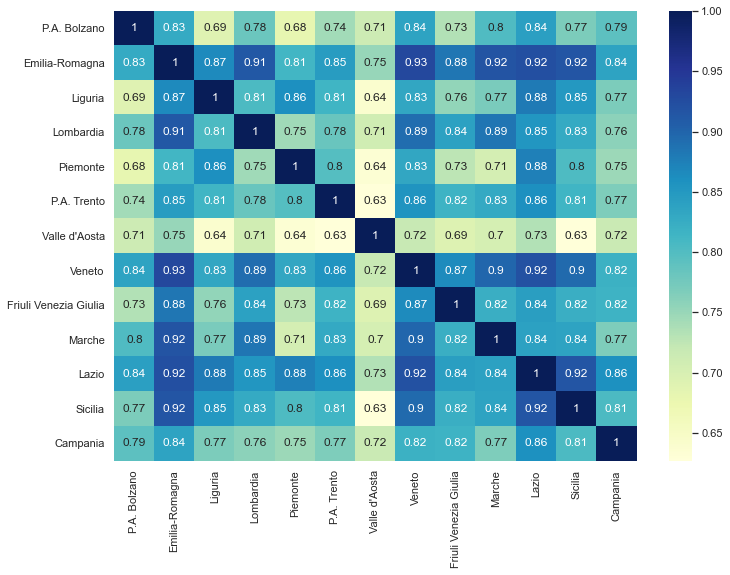

In [132]:
corrMatrix = corr_df.corr()
sns.heatmap(corrMatrix, annot=True, cmap="YlGnBu")
plt.show()

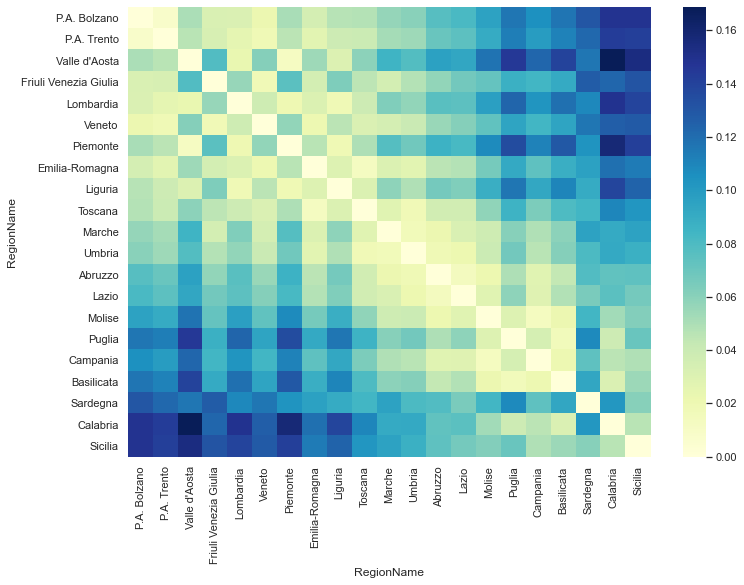

In [133]:
from sklearn.neighbors import DistanceMetric
lat_df['Latitude'] = np.radians(lat_df['Latitude'])
lat_df['Longitude'] = np.radians(lat_df['Longitude'])
dist = DistanceMetric.get_metric('haversine')
dist_matrix = dist.pairwise(lat_df[['Latitude', 'Longitude']]) #[lat_df['RegionName'].isin(selected_regions)]
dist_df = pandas.DataFrame(dist_matrix, columns=lat_df['RegionName'])
dist_df.set_index(lat_df['RegionName'], inplace=True)
sns.heatmap(dist_df, cmap="YlGnBu")
plt.show()

In [134]:
dist_df

RegionName,P.A. Bolzano,P.A. Trento,Valle d'Aosta,Friuli Venezia Giulia,Lombardia,Veneto,Piemonte,Emilia-Romagna,Liguria,Toscana,...,Umbria,Abruzzo,Lazio,Molise,Puglia,Campania,Basilicata,Sardegna,Calabria,Sicilia
RegionName,,,,,,,,,,,,,,,,,,,,,
P.A. Bolzano,0.000000,0.008031,0.050605,0.032748,0.031857,0.022068,0.051189,0.034994,0.046990,0.047665,...,0.060573,0.076734,0.081625,0.095665,0.116612,0.105303,0.116677,0.130322,0.148500,0.148581
P.A. Trento,0.008031,0.000000,0.046522,0.032994,0.025749,0.018498,0.045481,0.027614,0.039496,0.040172,...,0.054043,0.070857,0.074866,0.090446,0.112715,0.099490,0.111815,0.122360,0.143412,0.141796
Valle d'Aosta,0.050605,0.046522,0.000000,0.078602,0.023320,0.061513,0.012406,0.054066,0.030505,0.059652,...,0.078072,0.096430,0.093404,0.117867,0.145177,0.122633,0.139776,0.116135,0.168720,0.154331
Friuli Venezia Giulia,0.032748,0.032994,0.078602,0.000000,0.056026,0.017873,0.075307,0.036065,0.063424,0.045249,...,0.047598,0.057751,0.067532,0.072294,0.088183,0.084172,0.091198,0.127264,0.123202,0.131594
Lombardia,0.031857,0.025749,0.023320,0.056026,0.000000,0.038546,0.019774,0.031518,0.018691,0.039193,...,0.057375,0.075851,0.074945,0.097148,0.123400,0.103269,0.119149,0.109114,0.149130,0.139263
Veneto,0.022068,0.018498,0.061513,0.017873,0.038546,0.000000,0.057566,0.020517,0.045716,0.032032,...,0.040639,0.055446,0.061849,0.073764,0.094666,0.083813,0.094638,0.116242,0.126506,0.128434
Piemonte,0.051189,0.045481,0.012406,0.075307,0.019774,0.057566,0.000000,0.046460,0.019347,0.050035,...,0.068252,0.086339,0.082319,0.107723,0.135721,0.111751,0.129482,0.103897,0.157800,0.142200
Emilia-Romagna,0.034994,0.027614,0.054066,0.036065,0.031518,0.020517,0.046460,0.000000,0.030047,0.012702,...,0.027573,0.045591,0.047673,0.066460,0.091954,0.073898,0.088393,0.096583,0.119099,0.114427
Liguria,0.046990,0.039496,0.030505,0.063424,0.018691,0.045716,0.019347,0.030047,0.000000,0.031204,...,0.049147,0.067082,0.063050,0.088433,0.116647,0.092434,0.110155,0.090720,0.138499,0.124255


In [135]:
closest_regions = {}
for region in regions:
    closest_regions[region] = dist_df.loc[region].sort_values().iloc[1:10].index.values

In [136]:
def create_sequences(values, window_size=7):
    output = []
    for i in range(len(values) - window_size + 1):
        output.append(values[i : (i + window_size)])
    return np.stack(output)

In [137]:
temporal_dataset = {}
for region in regions:
    x = create_sequences(df_for_regions[region].to_numpy())
    temporal_dataset[region] = x

In [138]:
spatio_temporal_dataset = {}
for region in regions:
    result = []
    result.append(dataset[region])
    neighbours = closest_regions[region]
    for neighbour in neighbours:
        result.append(dataset[neighbour])
    spatio_temporal_dataset[region] = np.stack(result, axis=3)
    

In [139]:
spatio_temporal_dataset['Abruzzo'].shape

(144, 7, 8, 10)

In [140]:
train_dataset = np.vstack([spatio_temporal_dataset[region] for region in train_regions])
train_labels = np.vstack([temporal_dataset[region] for region in train_regions])

cv_dataset = np.vstack([spatio_temporal_dataset[region] for region in cv_regions])
cv_labels = np.vstack([temporal_dataset[region] for region in cv_regions])

test_dataset = np.vstack([spatio_temporal_dataset[region] for region in test_regions])
test_labels = np.vstack([temporal_dataset[region] for region in test_regions])

In [141]:
print(train_dataset.shape, train_labels.shape)

(1296, 7, 8, 10) (1296, 7, 8)


In [142]:
from torch.utils.data import TensorDataset, DataLoader
batch_size = 16 # mini-batch size
num_workers = 4 # how many parallel workers are we gonna use for reading data
shuffle = False

x_train = torch.tensor(train_dataset)
y_train = torch.tensor(train_labels)
tensor_train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(tensor_train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)
train_loader